# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

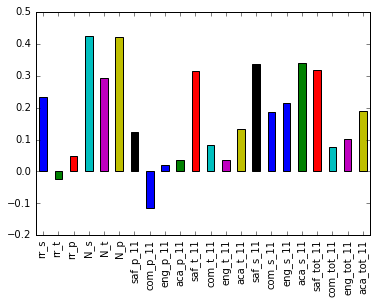

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

From the barplot above one can see some interesting correlations; safety and respect reported by techers (saf_t_11) has a quite high correlation with the st score as well as the safety and respect reported by the students. The academic expectations reported by students (aca_s_11) also has a quite high correlation with the sat score. High rescpect and safety should contribute to a better environment for the students, and teachers, creating a better environment for studying and thus a higher sat score.

If the students have higher academic expectations they most likely also will try to perform better on the sat test thus leading to a higher score and higher correlation.

The number of student respondents (N_s), the number of parent respondents (N_p), and the number of teacher respondents (N_t) have positive and high correlation with the sat score, these columns are correlated with the total enrollment, which then explains the high correlations with the sat_score. It is also interesting to see that the student response rate have a positive correlation with the sat_score, this might be explained by that students who are good at filling out forms, also perform better at the sat tests.

# Exploring safety and SAT scores

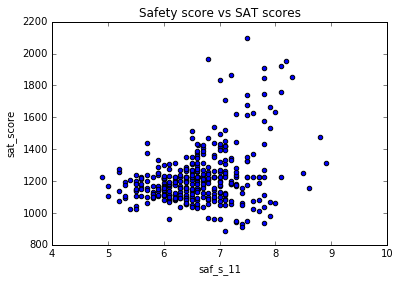

In [12]:
ax1 = combined.plot.scatter(x='saf_s_11', y='sat_score', 
                            title='Safety score vs SAT scores')

There seems to be a correlation between SAT scores and safety, however, it does not seem to be that strong. It looks like there are some schools with very high SAT scores and high safety and there are some schools with low SAT score and low safety. But still the data is quite spread out; there are schools with low safety but still quite high SAT scores and there are schools with high safety and low SAT score.  

# Plot safety

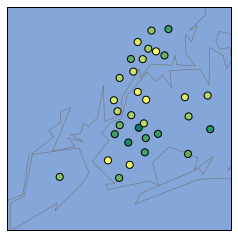

In [23]:
# create a map of New york city
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255753,
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

It is hard to see any clear pattern regarding safety by geographic area since it is quite spread out through the different neighboorhoods. But it seems like Manhattan and some parts of Queens have a higher safety score than for example Bronx.

# Exploring race and SAT scores

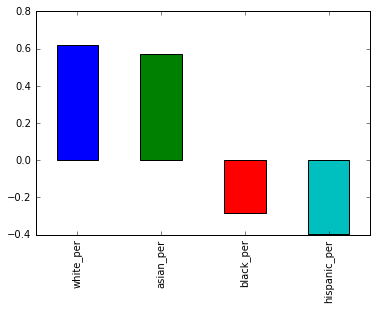

In [24]:
race_per_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][race_per_fields].plot.bar()

High white and/or asian percentage seems to have a positive correlation with SAT score, while a higher percentage of black and/or hispanic seems to have a negative correlation with SAT score.

### High hispanic percentage and SAT score

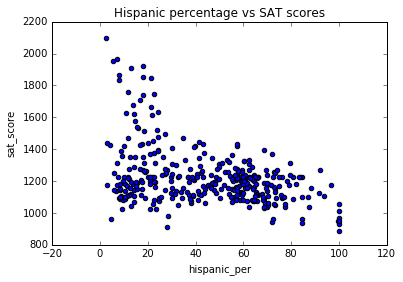

In [26]:
combined.plot.scatter(x='hispanic_per', y='sat_score', 
                            title='Hispanic percentage vs SAT scores')

From the scatter plot it seems like a higher percentage of hispanic have a negative correlation with SAT score. But around 25% hispanic the decrease in SAT score flattens out and a higher hispanic percentage than 25 does not seem to change the SAT score that much more.

In [28]:
school_names = combined['school_name'][combined['hispanic_per'] > 95]
print(school_names)

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


The above schools seems to be geared towards recent immigrants to the US, which can explain the low SAT scores.

In [30]:
print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['school_name'])

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


All of these schools have a special test that students needs to take in order to get admitted. Moreover these are specialized in science and technology and get more funding, this does not explain the low hispanic percentage but it does explain the high sat scores.

# Exploring gender and SAT scores

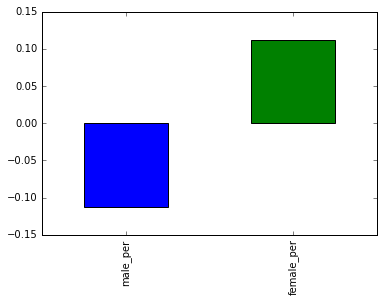

In [31]:
gender_fields= ['male_per', 'female_per']
combined.corr()["sat_score"][gender_fields].plot.bar()

A higher percentage of male students seems to correlate negatively with the SAT score, whereas a higher percentage of female students seems to correlate positively with the SAT score. But the correlations are not that strong.

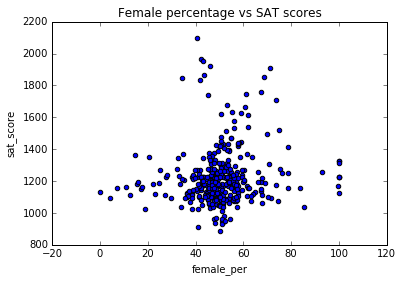

In [32]:
combined.plot.scatter(x='female_per', y='sat_score', 
                            title='Female percentage vs SAT scores')

The scatter plot shows that the correlation of a higher percentage of female students has a low correlation with the SAT score. There are no obvious trends that can be seen in the scatter plot.

In [35]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['school_name'])

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object


These schools seem to be very selective liberal arts schools with a high academic profile.

# Exploring AP scores vs SAT scores

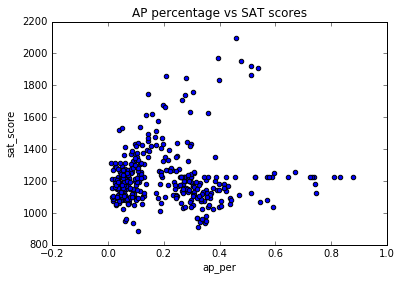

In [37]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score', 
                            title='AP percentage vs SAT scores')

Looks like there might be a weak correlation between how many students that take the AP exams and the SAT score.